# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import scvi
import scrnatools as rna
import seaborn as sns
import pandas as pd
from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import numpy as np
import pickle
import logging
import scipy
from scipy.stats import spearmanr, pearsonr
import scanpy as sc

In [3]:
# Set seeds
scvi.settings.seed = 0
scvi.settings.verbosity = logging.WARNING

Global seed set to 0


In [4]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Helvetica"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.unicode_minus'] = False

In [5]:
warnings.resetwarnings()

# Import data

Data paths

In [6]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [7]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

In [8]:
adata = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/combined_all_genes_TECs.h5ad")
model = scvi.model.SCVI.load(
    f"{processedDataPath}/Fezf2_thymus_paper/scVI_models/combined_all_genes",
    adata=adata,
)

# scVI DE

In [9]:
def scvi_cell_type_de(
    adata, 
    cell_type_key, 
    group_key, condition_group, control_group, 
    min_cells
):
    all_genes = pd.DataFrame()

    for cell_type in adata.obs[cell_type_key].unique():
        subset_data = adata[adata.obs[cell_type_key] == cell_type].copy()
        num_control = sum([i == control_group for i in subset_data.obs[group_key]])
        num_condition = sum([i == condition_group for i in subset_data.obs[group_key]])
        if num_control > min_cells and num_condition > min_cells:
            print(cell_type)
            de_genes = model.differential_expression(
                adata=subset_data,
                groupby=group_key,
                group1=condition_group,
                group2=control_group,
                silent=True,
            )
            de_genes["cell_type"] = cell_type
            all_genes = pd.concat([all_genes, de_genes])
        else:
            print(f"{cell_type} had too few cells in at least one group, skipping")

    all_genes["gene"] = all_genes.index
    all_genes.index = all_genes.index + "_" + all_genes.cell_type
    all_genes = all_genes.sort_index()
    all_genes["abs_lfc"] = abs(all_genes.lfc_mean)
    
    return all_genes

def filter_scvi_de_genes(
    adata, 
    df, 
    bayes_thresh, lfc_thresh, nonzero_thresh, 
    percentile, cell_type_key, expression_layer, peak_expression_thresh, 
    ylim=None, *args, **kwargs
):
    for cell_type in df.cell_type.unique():
        expression = rna.tl.get_expression_matrix(
            adata[adata.obs[cell_type_key] == cell_type],
            expression_layer
        )
        percentile_expression = pd.DataFrame(
            np.quantile(expression, percentile, axis=0),
            index=[f"{i}_{cell_type}" for i in expression.columns]
        )
        df.loc[percentile_expression.index, f"expression_{percentile}"] = percentile_expression[0]
    detected_genes = df[df[f"expression_{percentile}"] > peak_expression_thresh].copy()
    detected_genes = detected_genes[
        (detected_genes.non_zeros_proportion1 > nonzero_thresh) |
        (detected_genes.non_zeros_proportion2 > nonzero_thresh)
    ]
    
    ax = sns.scatterplot(
        x=detected_genes.lfc_mean,
        y=detected_genes.bayes_factor,
        linewidth=0,
        s=1,
        *args, **kwargs
    )
    plt.axhline(y=bayes_thresh, c="black")
    plt.axvline(x=lfc_thresh, c="black")
    plt.axvline(x=-1*lfc_thresh, c="black")
    if ylim is not None:
        plt.ylim(ylim)
    plt.show()
    
    filtered_genes = detected_genes[detected_genes.bayes_factor > bayes_thresh].copy()
    filtered_genes = filtered_genes[abs(filtered_genes.lfc_mean) > lfc_thresh]
    
    return detected_genes, filtered_genes

## Run DE

In [10]:
all_genes = {}
for sample in adata.obs["sample"].unique():
    subset_data = adata[adata.obs["sample"] == sample]
    for genotype in ["Aire", "Fezf2"]:
        data = subset_data[subset_data.obs.batch.str.contains(genotype)]
        print(f"{genotype}-{sample}")
        all_gene = scvi_cell_type_de(
            adata=data,
            cell_type_key="majority_voting",
            group_key="genotype",
            condition_group=f"{genotype}_KO",
            control_group="WT",
            min_cells=30,
        )
        all_genes[f"{genotype}-{sample}"] = all_gene
        print()

Aire-1
Gut/Liver
Tuft2
Aire-stage
Immature MEC
Ciliated had too few cells in at least one group, skipping
Lung, basal
Tuft1
Skin, keratinized had too few cells in at least one group, skipping
Skin, basal
TA MEC
Neuroendocrine
Mcell
adult cTEC had too few cells in at least one group, skipping
Goblet
perinatal cTEC had too few cells in at least one group, skipping

Fezf2-1
Gut/Liver
Tuft2
Immature MEC
Aire-stage
adult cTEC
Lung, basal
Mcell
Neuroendocrine
Skin, keratinized had too few cells in at least one group, skipping
Tuft1 had too few cells in at least one group, skipping
Goblet
TA MEC
Skin, basal
perinatal cTEC had too few cells in at least one group, skipping
Ciliated had too few cells in at least one group, skipping

Aire-2
Immature MEC
Aire-stage
TA MEC
Ciliated had too few cells in at least one group, skipping
Neuroendocrine
Skin, basal
Gut/Liver
Lung, basal
Tuft2
Mcell
perinatal cTEC had too few cells in at least one group, skipping
adult cTEC had too few cells in at least one

## Filter

Aire-1


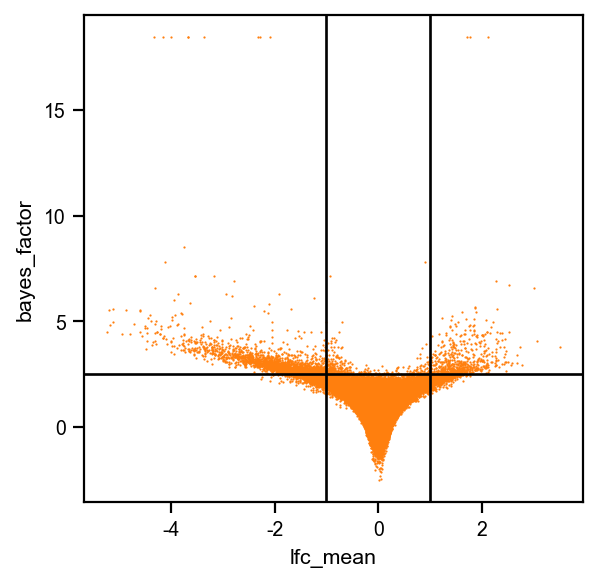

Fezf2-1


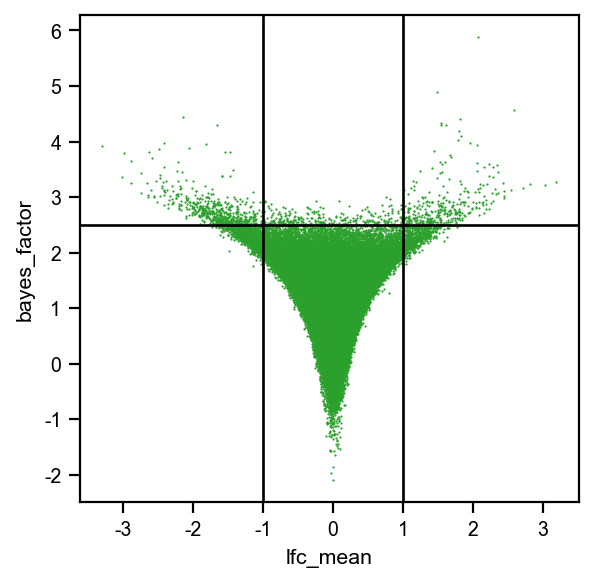

Aire-2


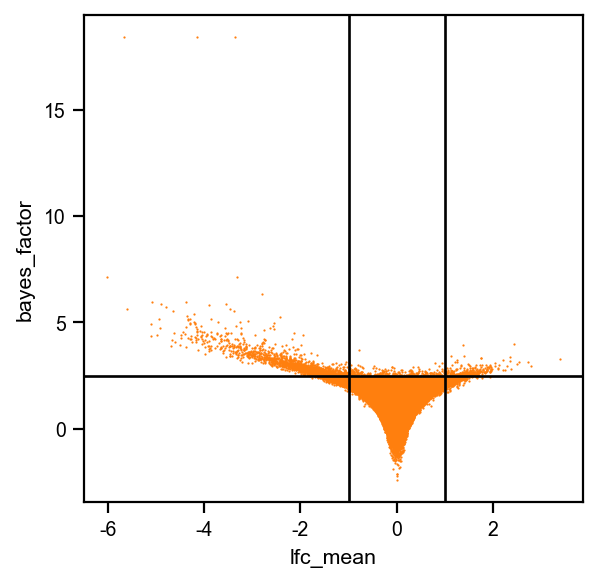

Fezf2-2


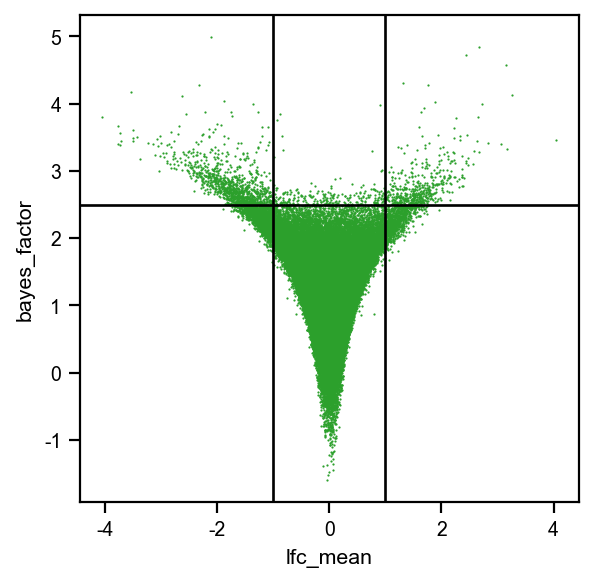

In [11]:
detected_genes = {}
filtered_genes = {}
for key, all_gene in all_genes.items():
    print(key)
    genotype, sample = key.split("-")
    if genotype == "Aire":
        color="tab:orange"
    else:
        color="tab:green"
    subset_data = adata[adata.obs.batch.str.contains(genotype) & (adata.obs["sample"] == sample)]
    detected_gene, filtered_gene = filter_scvi_de_genes(
        adata=subset_data,
        cell_type_key="majority_voting",
        expression_layer="scVI_normalized",
        df=all_gene,
        bayes_thresh=2.5,
        lfc_thresh=1,
        nonzero_thresh=0.05,
        percentile=0.99,
        peak_expression_thresh=0.5,
        color=color
    )
    detected_genes[key] = detected_gene
    filtered_genes[key] = filtered_gene

## WT DE

In [12]:
all_genes_WT = {}
for genotype in ["Aire", "Fezf2"]:
    data = adata[adata.obs.batch.str.contains(f"{genotype}_WT")]
    print(f"{genotype}")
    all_gene = scvi_cell_type_de(
        adata=data,
        cell_type_key="majority_voting",
        group_key="sample",
        condition_group="1",
        control_group="2",
        min_cells=30,
    )
    all_genes_WT[genotype] = all_gene
    print()

Aire
Gut/Liver
Tuft2
Aire-stage
Immature MEC
Ciliated
Lung, basal
Tuft1
Skin, keratinized had too few cells in at least one group, skipping
Skin, basal
TA MEC
Neuroendocrine
Mcell
adult cTEC
Goblet
perinatal cTEC had too few cells in at least one group, skipping

Fezf2
Gut/Liver
Tuft2
Immature MEC
Aire-stage
adult cTEC had too few cells in at least one group, skipping
Lung, basal
Mcell
Neuroendocrine
Skin, keratinized had too few cells in at least one group, skipping
Tuft1
Goblet
TA MEC
Skin, basal
perinatal cTEC had too few cells in at least one group, skipping
Ciliated



Aire


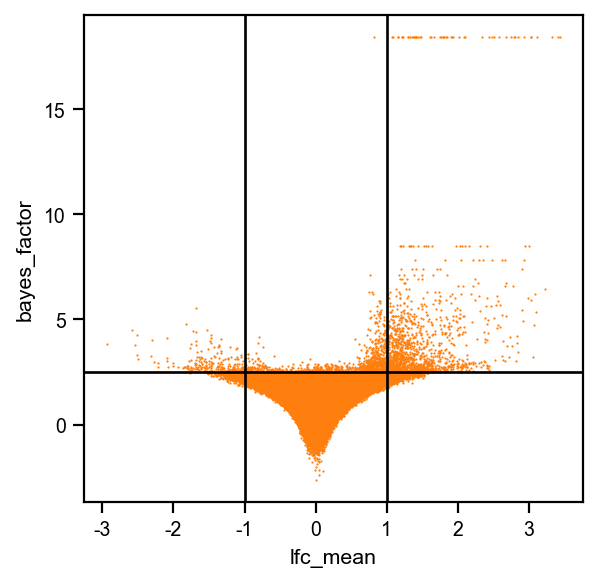

Fezf2


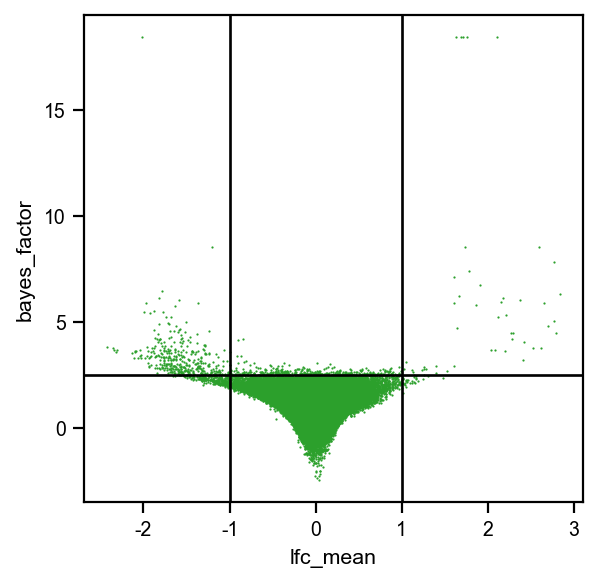

In [13]:
detected_genes_WT = {}
filtered_genes_WT = {}
for key, all_gene in all_genes_WT.items():
    print(key)
    if key == "Aire":
        color="tab:orange"
    else:
        color="tab:green"
    subset_data = adata[adata.obs.batch.str.contains(f"{key}_WT")]
    detected_gene, filtered_gene = filter_scvi_de_genes(
        adata=subset_data,
        cell_type_key="majority_voting",
        expression_layer="scVI_normalized",
        df=all_gene,
        bayes_thresh=2.5,
        lfc_thresh=1,
        nonzero_thresh=0.05,
        percentile=0.99,
        peak_expression_thresh=0.5,
        color=color
    )
    detected_genes_WT[key] = detected_gene
    filtered_genes_WT[key] = filtered_gene

In [14]:
for key, filtered_gene in filtered_genes.items():
    WT_filtered = filtered_genes_WT[key.split("-")[0]]
    filtered_gene = filtered_gene[~filtered_gene.gene.isin(WT_filtered.gene)]

## KO DE

In [15]:
all_genes_KO = {}
for genotype in ["Aire", "Fezf2"]:
    data = adata[adata.obs.genotype == f"{genotype}_KO"]
    print(f"{genotype}")
    all_gene = scvi_cell_type_de(
        adata=data,
        cell_type_key="majority_voting",
        group_key="sample",
        condition_group="1",
        control_group="2",
        min_cells=30,
    )
    all_genes_KO[genotype] = all_gene
    print()

Aire
Aire-stage
TA MEC
Immature MEC
Tuft2
Gut/Liver
Mcell
Lung, basal
Goblet
Neuroendocrine
adult cTEC had too few cells in at least one group, skipping
Tuft1
Skin, basal
Skin, keratinized had too few cells in at least one group, skipping
perinatal cTEC had too few cells in at least one group, skipping
Ciliated had too few cells in at least one group, skipping

Fezf2
Immature MEC
Aire-stage
TA MEC
Gut/Liver
Goblet
Neuroendocrine
Lung, basal
Skin, keratinized
Tuft2
Mcell
adult cTEC
Skin, basal
Ciliated had too few cells in at least one group, skipping
Tuft1 had too few cells in at least one group, skipping
perinatal cTEC had too few cells in at least one group, skipping



Aire


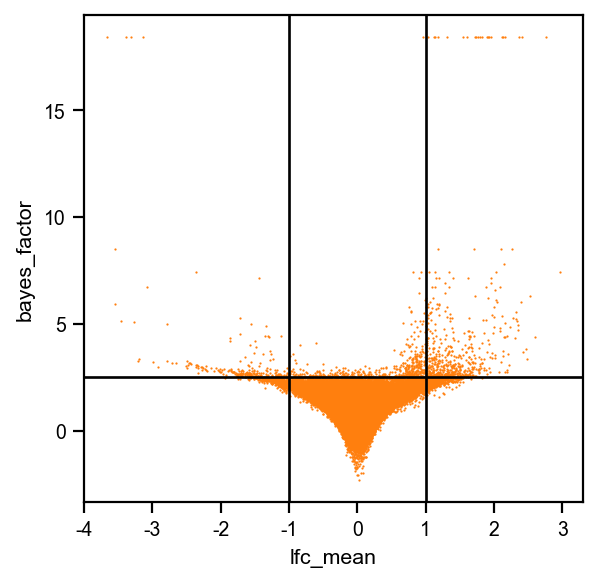

Fezf2


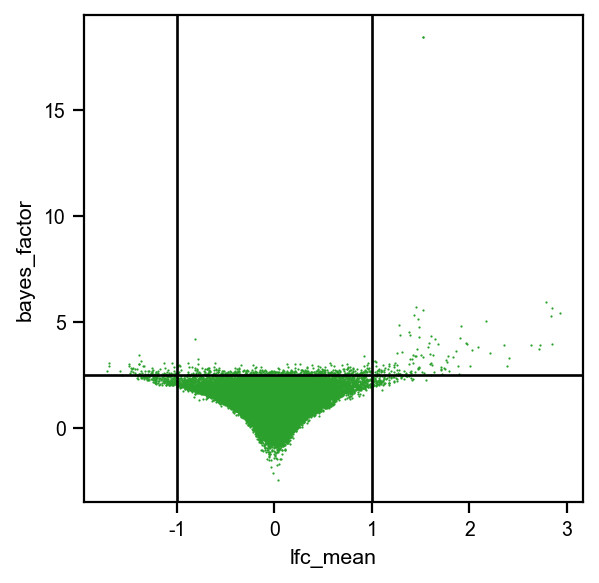

In [16]:
detected_genes_KO = {}
filtered_genes_KO = {}
for key, all_gene in all_genes_KO.items():
    print(key)
    if key == "Aire":
        color="tab:orange"
    else:
        color="tab:green"
    subset_data = adata[adata.obs.genotype == f"{key}_KO"]
    detected_gene, filtered_gene = filter_scvi_de_genes(
        adata=subset_data,
        cell_type_key="majority_voting",
        expression_layer="scVI_normalized",
        df=all_gene,
        bayes_thresh=2.5,
        lfc_thresh=1,
        nonzero_thresh=0.05,
        percentile=0.99,
        peak_expression_thresh=0.5,
        color=color
    )
    detected_genes_KO[key] = detected_gene
    filtered_genes_KO[key] = filtered_gene

In [17]:
for key, filtered_gene  in filtered_genes.items():
    KO_filtered = filtered_genes_KO[key.split("-")[0]]
    filtered_gene = filtered_gene[~filtered_gene.gene.isin(KO_filtered.gene)]

## Sample reproducibility

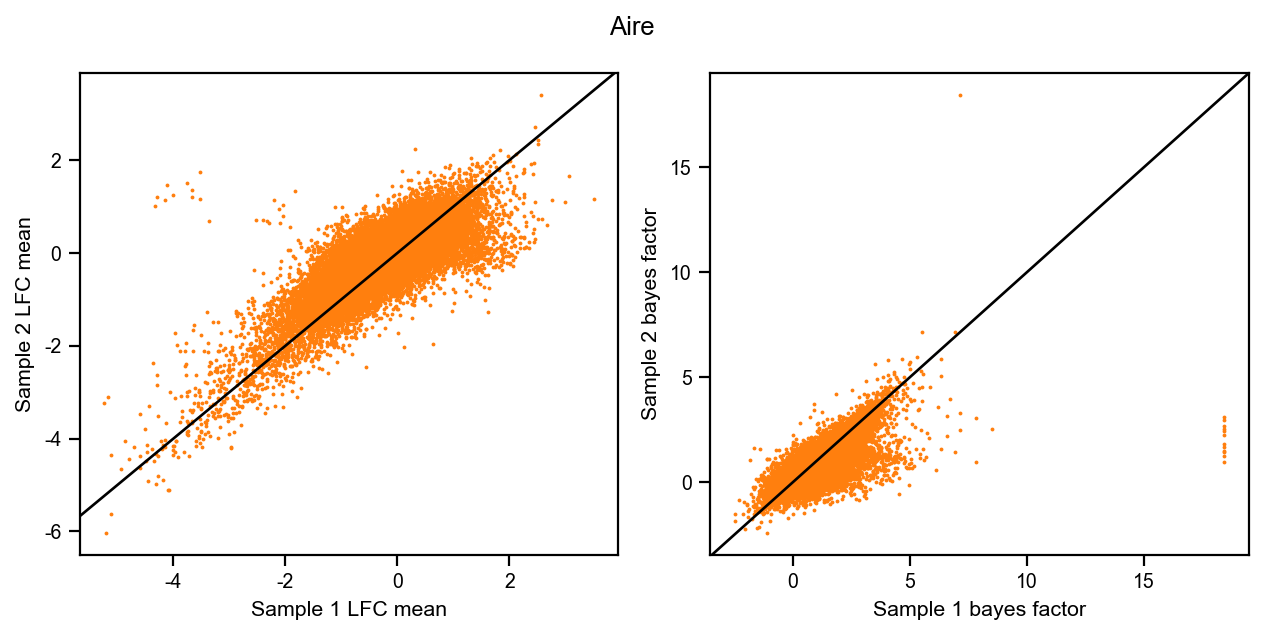

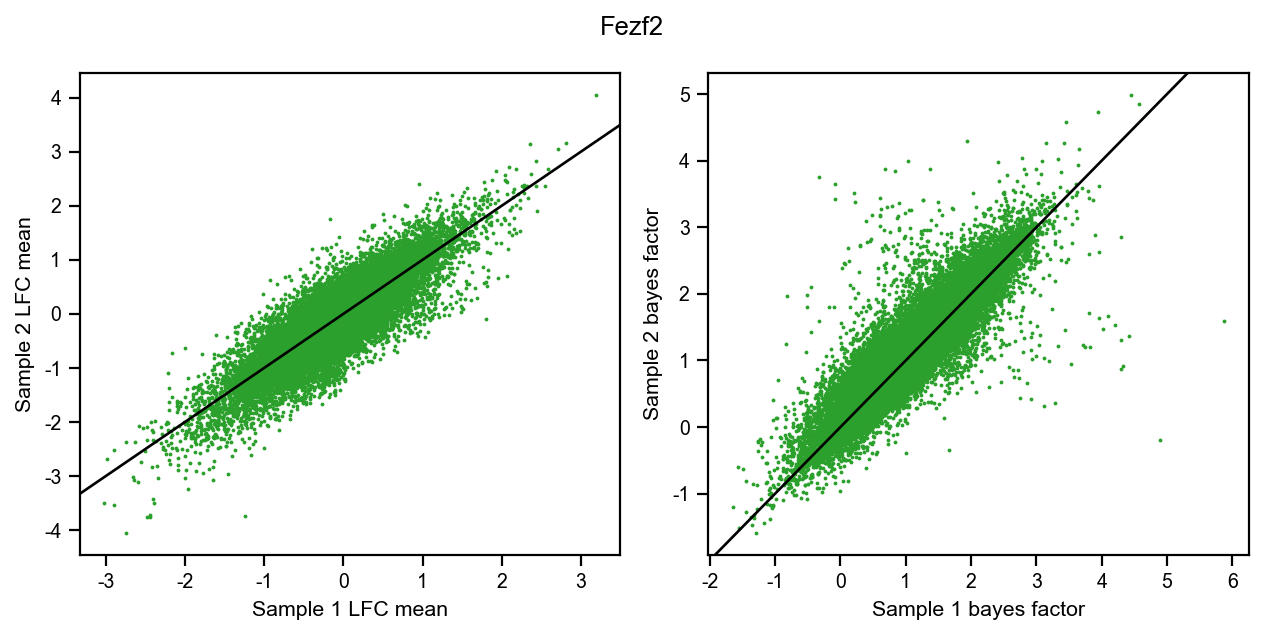

In [18]:
for genotype in ["Aire", "Fezf2"]:
    sample_1 = detected_genes[f"{genotype}-1"]
    sample_2 = detected_genes[f"{genotype}-2"]
    if genotype == "Aire":
        color="tab:orange"
    else:
        color="tab:green"
    
    fig = plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    ax = sns.scatterplot(
        x=sample_1.lfc_mean,
        y=sample_2.lfc_mean,
        linewidth=0,
        s=3,
        c=color
    )
    ax.axline((0, 0), slope=1, c="black")
    ax.set_xlabel("Sample 1 LFC mean")
    ax.set_ylabel("Sample 2 LFC mean")
    
    plt.subplot(1,2,2)
    ax = sns.scatterplot(
        x=sample_1.bayes_factor,
        y=sample_2.bayes_factor,
        linewidth=0,
        s=3,
        c=color
    )
    ax.axline((0, 0), slope=1, c="black")
    ax.set_xlabel("Sample 1 bayes factor")
    ax.set_ylabel("Sample 2 bayes factor")
    
    plt.suptitle(genotype)
    plt.tight_layout()
    plt.show()

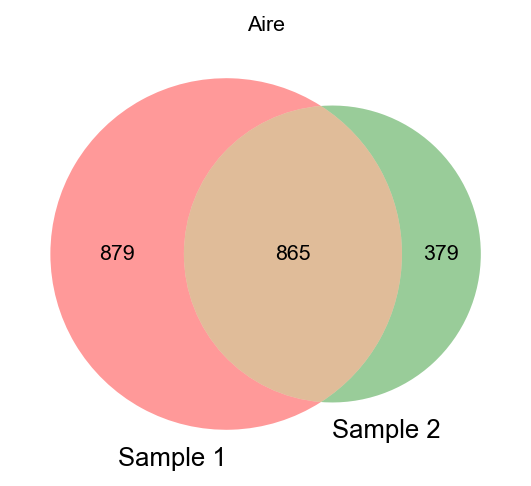

Aire % shared: 40.74


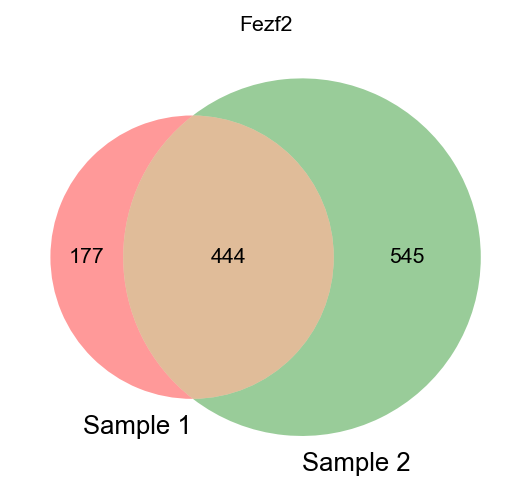

Fezf2 % shared: 38.08


In [19]:
for genotype in ["Aire", "Fezf2"]:
    sample_1 = filtered_genes[f"{genotype}-1"]
    sample_2 = filtered_genes[f"{genotype}-2"]

    both_genes = {i for i in sample_1.gene if i in sample_2.gene.tolist()}
    sample_1_genes = {i for i in sample_1.gene if i not in both_genes}
    sample_2_genes = {i for i in sample_2.gene if i not in both_genes}
    
    for sample in ["1", "2"]:
        filtered_genes[f"{genotype}-{sample}"].loc[
            filtered_genes[f"{genotype}-{sample}"].gene.isin(both_genes),
            "sample"
        ] = "both"
        filtered_genes[f"{genotype}-{sample}"].loc[
            filtered_genes[f"{genotype}-{sample}"].gene.isin(sample_1_genes),
            "sample"
        ] = "1"
        filtered_genes[f"{genotype}-{sample}"].loc[
            filtered_genes[f"{genotype}-{sample}"].gene.isin(sample_2_genes),
            "sample"
        ] = "2"
    
    venn2(subsets = (len(sample_1_genes), len(sample_2_genes), len(both_genes)), set_labels = ('Sample 1', 'Sample 2'))
    plt.title(genotype)
    plt.show()
    print(f"{genotype} % shared: {round(len(both_genes)/(len(both_genes)+len(sample_1_genes)+len(sample_2_genes))*100, 2)}")

## Take intersection

In [20]:
for genotype in ["Aire", "Fezf2"]:
    sample_1 = filtered_genes[f"{genotype}-1"]
    sample_2 = filtered_genes[f"{genotype}-2"]
    sample_1 = sample_1[sample_1["sample"] == "both"]
    sample_1.index = sample_1.index + "_" + "1"
    sample_2 = sample_2[sample_2["sample"] == "both"]
    sample_2.index = sample_2.index + "_" + "2"
    merged_df = pd.concat([sample_1, sample_2])
    filtered_genes[genotype] = merged_df
    filtered_genes[f"{genotype}_max_LFC"] = merged_df.sort_values(by="abs_lfc").drop_duplicates(subset="gene")
    filtered_genes[f"{genotype}_max_LFC"].index = filtered_genes[f"{genotype}_max_LFC"].gene

# Num regulated genes comparison

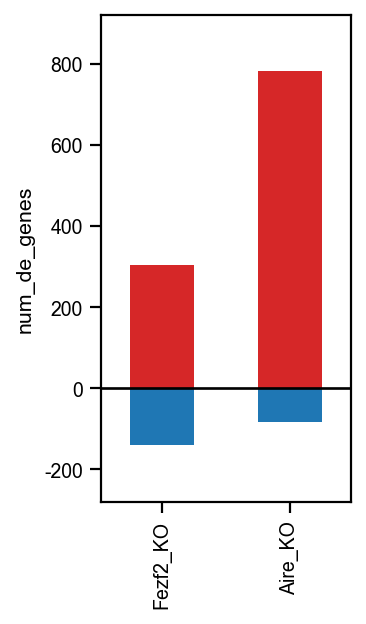

In [21]:
plotData = {}
plotData["up"] = [sum(filtered_genes["Fezf2_max_LFC"].lfc_mean > 0), sum(filtered_genes["Aire_max_LFC"].lfc_mean > 0)]
plotData["down"] = [sum(filtered_genes["Fezf2_max_LFC"].lfc_mean < 0), sum(filtered_genes["Aire_max_LFC"].lfc_mean < 0)]

plotData = pd.DataFrame(plotData, index=["Fezf2_KO", "Aire_KO"])

fig=plt.figure(figsize=(2,4))
plt.bar(x=plotData.index, height=plotData.down, color='tab:red', width=0.5)
plt.bar(x=plotData.index, height=-plotData.up, color='tab:blue', width=0.5)
plt.xticks([0,1], plotData.index, rotation='vertical')
plt.ylabel("num_de_genes")
plt.axhline(y=0, c="black")
plt.margins(0.15)
plt.show()

In [22]:
print(f"Aire up: {sum(filtered_genes['Aire_max_LFC'].lfc_mean < 0)}")
print(f"Aire down: {sum(filtered_genes['Aire_max_LFC'].lfc_mean > 0)}")
print(f"Fezf2 up: {sum(filtered_genes['Fezf2_max_LFC'].lfc_mean < 0)}")
print(f"Fezf2 down: {sum(filtered_genes['Fezf2_max_LFC'].lfc_mean > 0)}")

Aire up: 782
Aire down: 83
Fezf2 up: 303
Fezf2 down: 141


# Fezf2 regulated genes

In [23]:
fezf2_regulated_genes_data=pd.read_csv("../analysis/Fezf2_microarray_DE_genes.csv", index_col=0)
fezf2_regulated_genes_data["-10logp"] = -1*np.log10(fezf2_regulated_genes_data["adj.P.Val"])

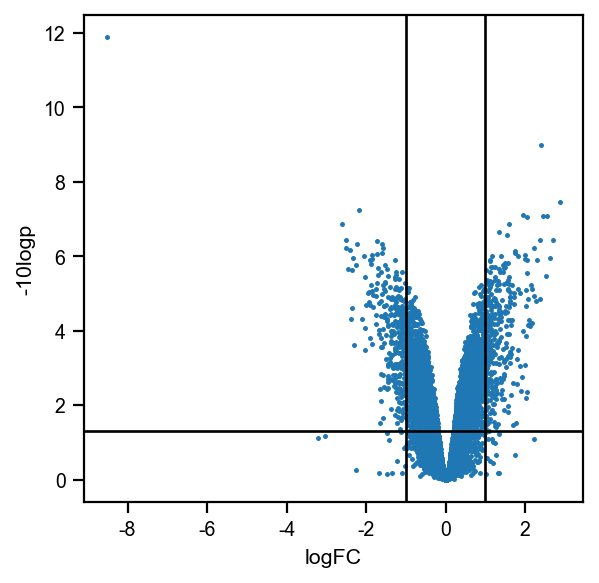

In [24]:
sns.scatterplot(
    fezf2_regulated_genes_data,
    x="logFC",
    y="-10logp",
    linewidth=0,
    s=5
)
plt.axhline(y=-1*np.log10(0.05), c="black")
plt.axvline(x=-1, c="black")
plt.axvline(x=1, c="black")
plt.show()

In [25]:
fezf2_regulated_genes_data = fezf2_regulated_genes_data[fezf2_regulated_genes_data["adj.P.Val"] < 0.05]
fezf2_regulated_genes_data = fezf2_regulated_genes_data[abs(fezf2_regulated_genes_data.logFC) > 2]
fezf2_regulated_genes_data = fezf2_regulated_genes_data[fezf2_regulated_genes_data.symbols != "Fezf2"]

In [28]:
fezf2_regulated_genes = fezf2_regulated_genes_data.symbols.unique()

In [29]:
for genotype in ["Aire", "Fezf2"]:
    filtered_genes[f'{genotype}_max_LFC']["Fezf2_regulated"] = filtered_genes[f'{genotype}_max_LFC'].gene.isin(fezf2_regulated_genes)

In [30]:
filtered_genes['Aire_max_LFC'].Fezf2_regulated.sum()

11

In [31]:
filtered_genes['Fezf2_max_LFC'].Fezf2_regulated.sum()

29

In [32]:
fezf2_genes_data = fezf2_regulated_genes_data[
    fezf2_regulated_genes_data.symbols.isin(filtered_genes["Fezf2_max_LFC"].gene)
].groupby("symbols").mean(numeric_only=True)
filtered_genes["Fezf2_max_LFC"]["microarray_lfc"] = fezf2_genes_data.logFC

data = filtered_genes["Fezf2_max_LFC"]
data = data[data.Fezf2_regulated]
spearmanr(data["microarray_lfc"], data["lfc_mean"])

SignificanceResult(statistic=0.7192118226600983, pvalue=1.1025099882656129e-05)

# Volcano plots

In [33]:
def volcanoplot(df, x, y, annotate_genes=None, save_path=None, annotate_genes_colors=None, *args, **kwargs):
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        linewidth=0,
        *args, **kwargs
    )
    for j,gene_list in enumerate(annotate_genes):
        if annotate_genes_colors is not None:
            color = annotate_genes_colors[j]
        else:
            color = "black"
        annotated_genes = df[df.gene.isin(gene_list)]
        texts = []
        for i, row in annotated_genes.iterrows():
            texts.append(
                plt.text(
                    row[x],
                    row[y],
                    row['gene'],
                    ha='center',
                    va='bottom',
                    fontsize=8, 
                    color=color
                )
            )
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color=color))
    plt.tight_layout()
    if save_path is not None:
        plt.save_fig(save_path)
    plt.show()

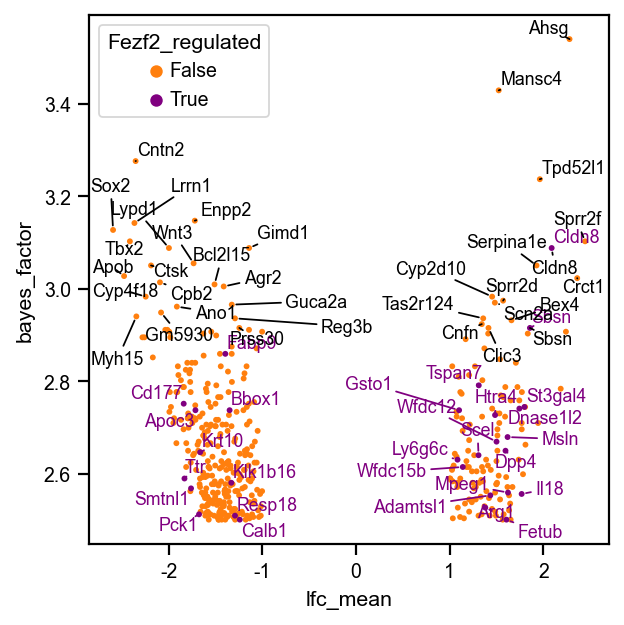

In [34]:
gene_lists = [
    fezf2_regulated_genes,
    filtered_genes["Fezf2_max_LFC"].sort_values(by="bayes_factor", ascending=False).head(35).gene
]
filtered_genes["Fezf2_max_LFC"] = filtered_genes["Fezf2_max_LFC"].sort_values(by="Fezf2_regulated") 
volcanoplot(
    df=filtered_genes["Fezf2_max_LFC"],
    x="lfc_mean",
    y="bayes_factor",
    annotate_genes=gene_lists,
    annotate_genes_colors=["purple", "black"],
    hue="Fezf2_regulated",
    s=7,
    palette=["tab:orange", "purple"],
)

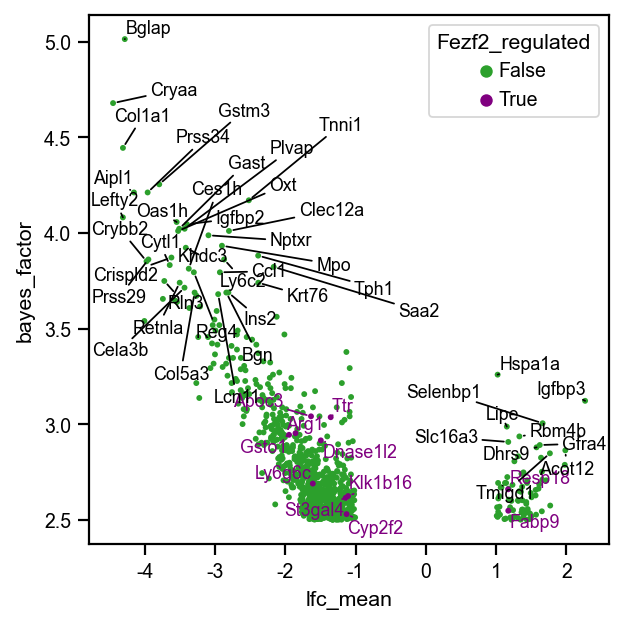

In [35]:
gene_lists = [
    fezf2_regulated_genes,
    filtered_genes["Aire_max_LFC"].sort_values(by="bayes_factor", ascending=False).head(35).gene,
    filtered_genes["Aire_max_LFC"][filtered_genes["Aire_max_LFC"].lfc_mean > 0].sort_values(by="bayes_factor", ascending=False).head(10).gene,
]
filtered_genes["Aire_max_LFC"] = filtered_genes["Aire_max_LFC"].sort_values(by="Fezf2_regulated") 
volcanoplot(
    df=filtered_genes["Aire_max_LFC"],
    x="lfc_mean",
    y="bayes_factor",
    annotate_genes=gene_lists,
    annotate_genes_colors=["purple", "black", "black"],
    hue="Fezf2_regulated",
    s=7,
    palette=["tab:green", "purple"],
    hue_order=[False, True]
)

# Transcription factors

In [36]:
TFs = list(pd.read_csv("../mouse_ensemble_tfs_from_lambertetal_isyes.unique.csv", header=None)[1])
TFs = [i for i in TFs if i in adata.var_names]

In [37]:
for genotype in ["Aire", "Fezf2"]:
    filtered_genes[f'{genotype}_max_LFC']["TF"] = filtered_genes[f'{genotype}_max_LFC'].gene.isin(TFs)

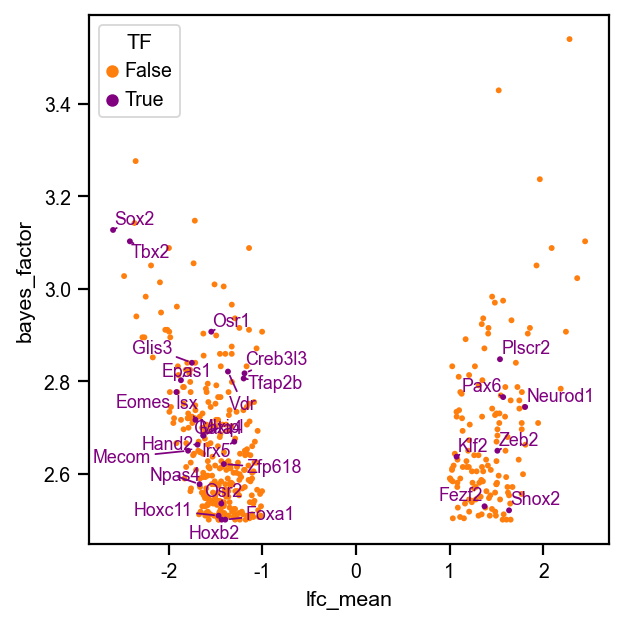

In [38]:
filtered_genes["Fezf2_max_LFC"] = filtered_genes["Fezf2_max_LFC"].sort_values(by="TF") 
volcanoplot(
    df=filtered_genes["Fezf2_max_LFC"],
    x="lfc_mean",
    y="bayes_factor",
    annotate_genes=[TFs],
    annotate_genes_colors=["purple", "black"],
    hue="TF",
    s=7,
    palette=["tab:orange", "purple"],
)

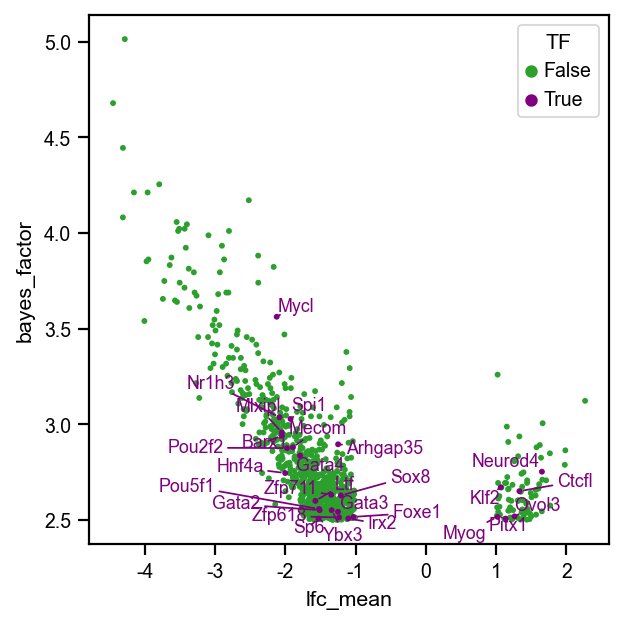

In [39]:
filtered_genes["Aire_max_LFC"] = filtered_genes["Aire_max_LFC"].sort_values(by="TF") 
volcanoplot(
    df=filtered_genes["Aire_max_LFC"],
    x="lfc_mean",
    y="bayes_factor",
    annotate_genes=[TFs],
    annotate_genes_colors=["purple", "black"],
    hue="TF",
    s=7,
    palette=["tab:green", "purple"],
)

# Induced/Repressed genes

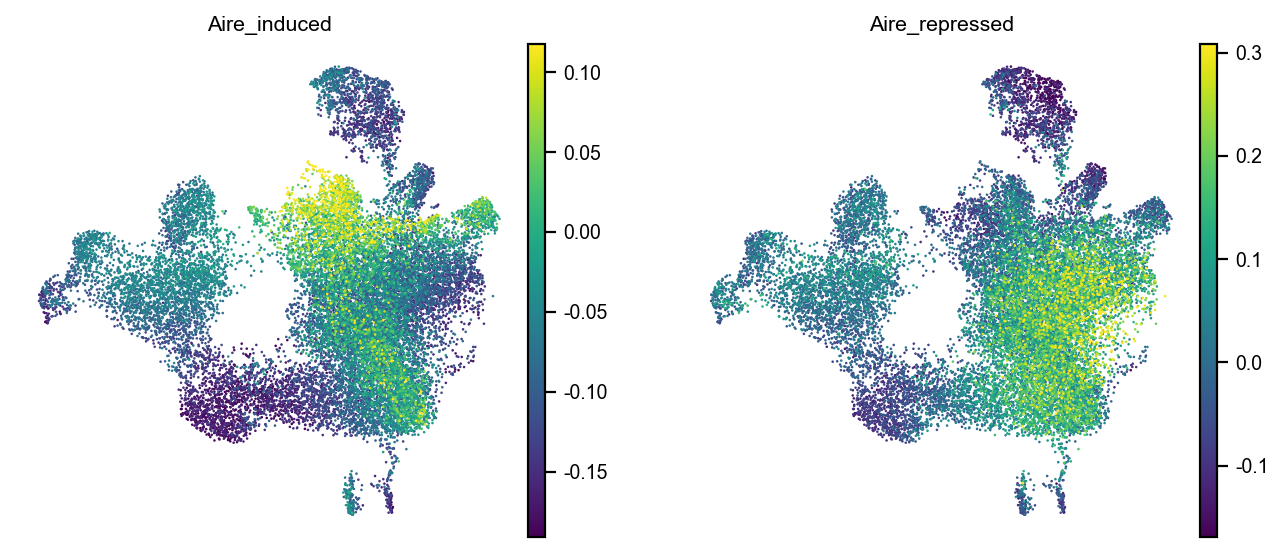

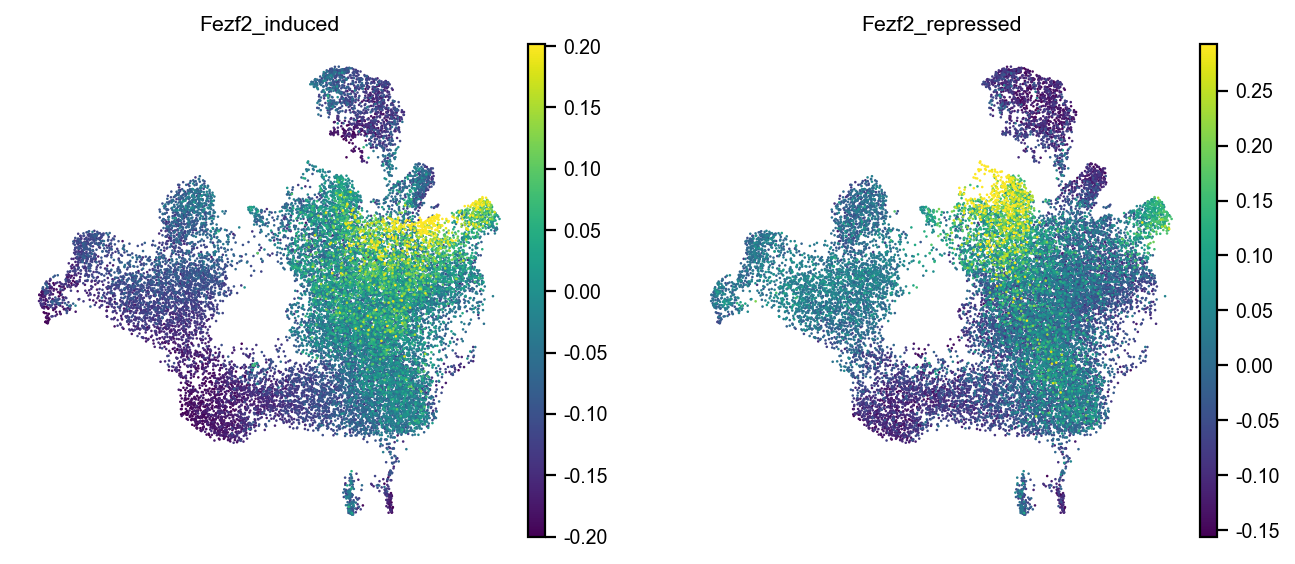

In [40]:
wtData = adata[adata.obs.genotype == "WT"].copy()
for genotype in ["Aire", "Fezf2"]:
    induced = filtered_genes[f"{genotype}_max_LFC"][filtered_genes[f"{genotype}_max_LFC"].lfc_mean < 0].gene.tolist()
    repressed = filtered_genes[f"{genotype}_max_LFC"][filtered_genes[f"{genotype}_max_LFC"].lfc_mean > 0].gene.tolist()

    sc.tl.score_genes(wtData, gene_list=induced, score_name=f"{genotype}_induced")
    sc.tl.score_genes(wtData, gene_list=repressed, score_name=f"{genotype}_repressed")
    
    vmin = []
    vmax = []
    for score in [f"{genotype}_induced", f"{genotype}_repressed"]:
        vmin.append(np.quantile(wtData.obs[score],0.01))
        vmax.append(np.quantile(wtData.obs[score],0.99))
    sc.pl.umap(
        wtData,
        color=[f"{genotype}_induced", f"{genotype}_repressed"],
        vmin=vmin,
        vmax=vmax
    )

# Aire-Fezf2 regulated genes overlap

In [41]:
shared_genes = filtered_genes["Aire_max_LFC"][filtered_genes["Aire_max_LFC"].gene.isin(filtered_genes["Fezf2_max_LFC"].gene)].copy()
fezf2 = filtered_genes["Fezf2_max_LFC"][~filtered_genes["Fezf2_max_LFC"].gene.isin(shared_genes.gene)]
aire = filtered_genes["Aire_max_LFC"][~filtered_genes["Aire_max_LFC"].gene.isin(shared_genes.gene)]

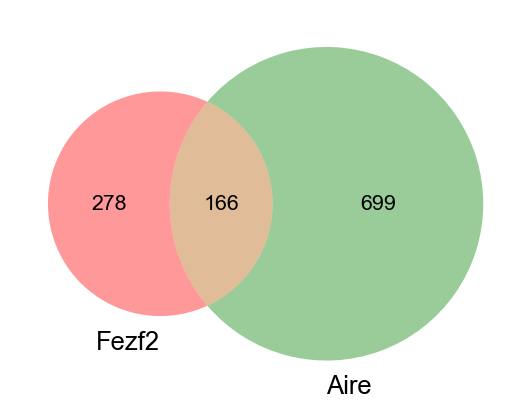

% shared: 14.52


In [42]:
venn2(subsets = (len(fezf2), len(aire), len(shared_genes)), set_labels = ('Fezf2', 'Aire'))
plt.show()
print(f"% shared: {round(len(shared_genes)/(len(shared_genes)+len(fezf2)+len(aire))*100, 2)}")

In [43]:
shared_genes["fezf2_lfc_mean"] = filtered_genes["Fezf2_max_LFC"].loc[shared_genes.gene, "lfc_mean"]

In [44]:
gene_list = shared_genes[shared_genes.lfc_mean < 0].sort_values(by="lfc_mean").head(10).gene.tolist()
gene_list += shared_genes[shared_genes.lfc_mean > 0].sort_values(by="lfc_mean", ascending=False).head(10).gene.tolist()
gene_list += shared_genes[shared_genes.fezf2_lfc_mean < 0].sort_values(by="fezf2_lfc_mean").head(10).gene.tolist()
gene_list += shared_genes[shared_genes.fezf2_lfc_mean > 0].sort_values(by="fezf2_lfc_mean", ascending=False).head(10).gene.tolist()
gene_list = set(gene_list)

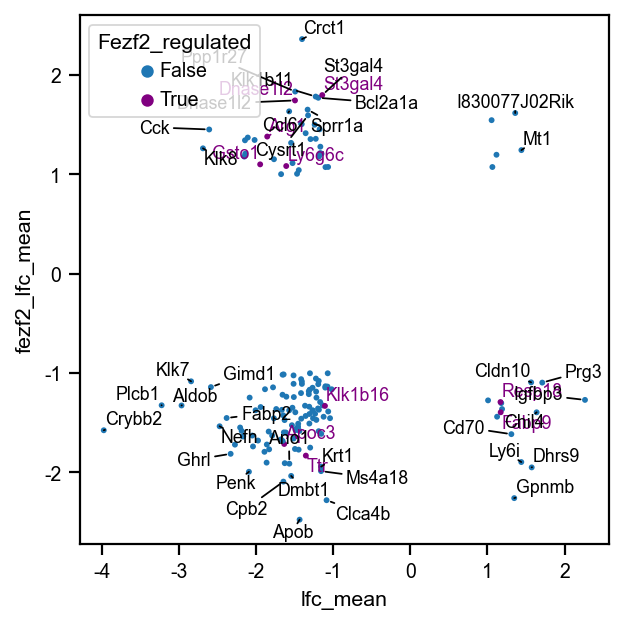

In [45]:
volcanoplot(
    df=shared_genes,
    x="lfc_mean",
    y="fezf2_lfc_mean",
    annotate_genes=[fezf2_regulated_genes, gene_list],
    annotate_genes_colors=["purple", "black"],
    s=7,
    hue="Fezf2_regulated",
    palette=["tab:blue", "purple"]
)

# Feature plots

In [46]:
def feature_plot(
    adata, 
    gene_list, 
    condition_key, condition_group, control_group, 
    gene_data, 
    *args, **kwargs
):
    vmin = []
    vmax = []
    for gene in gene_list:
        data = adata[adata.obs[condition_key] == control_group, gene].layers[gene_data]
        if scipy.sparse.issparse(data):
            data = data.todense().tolist()
        vmin.append(np.quantile(data, 0.01))
        vmax.append(np.quantile(data, 0.99))

    sc.pl.umap(
        adata[adata.obs[condition_key] == control_group],
        color=gene_list,
        layer=gene_data,
        vmin=vmin,
        vmax=vmax,
        *args, **kwargs
    )
    sc.pl.umap(
        adata[adata.obs[condition_key] == condition_group],
        color=gene_list,
        layer=gene_data,
        vmin=vmin,
        vmax=vmax,
        *args, **kwargs
    )

In [ ]:
gene_list = []
feature_plot(
    adata,
    gene_list=gene_list,
    condition_key="genotype",
    condition_group="Fezf2_KO",
    control_group="WT",
    gene_data="scVI_normalized",
    ncols=5,
)

# Save dictionaries

In [48]:
with open('../analysis/DE/filtered_genes.pkl', 'wb') as handle:
    pickle.dump(filtered_genes, handle)
    
with open('../analysis/DE/detected_genes.pkl', 'wb') as handle:
    pickle.dump(detected_genes, handle)
    
with open('../analysis/DE/all_genes.pkl', 'wb') as handle:
    pickle.dump(all_genes, handle)

# Load dictionaries

In [49]:
with open('../analysis/DE/filtered_genes.pkl', 'rb') as handle:
    filtered_genes = pickle.load(handle)
    
with open('../analysis/DE/detected_genes.pkl', 'rb') as handle:
    detected_genes = pickle.load(handle)
    
with open('../analysis/DE/all_genes.pkl', 'rb') as handle:
    all_genes = pickle.load(handle)